In [27]:
crop

TfmPixel (crop)

In [28]:
#export
from exp.nb_Tesis import *
path_to_2017_train_raw = Path('ISIC-2017_Training_Data/')
path_to_2018_train_raw = Path('ISIC2018_Task3_Training_Input/')
path_to_2019_train_raw = Path('ISIC_2019_Training_Input/')

path_to_2017_train_gt = Path('ISIC_2017_train_gt.csv')
path_to_2018_train_gt = Path('ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
path_to_2019_train_gt = Path('ISIC_2019_Training_GroundTruth.csv')

path_to_2018_test_raw = Path('ISIC2018_Task3_Test_Input/')
datasets = {
    '2017': {
        'train_images': path_to_2017_train_raw,
        'groundtruth': path_to_2017_train_gt
    },
    '2018': {
        'train_images': path_to_2018_train_raw,
        'groundtruth': path_to_2018_train_gt,
        'test_images': path_to_2018_test_raw
    },
    '2019': {
        'train_images': path_to_2019_train_raw,
        'groundtruth': path_to_2019_train_gt,
    }
}



In [42]:
#export
def resize_one(fn, i, path, size,path_hr, should_crop):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BICUBIC).convert('RGB')
    img.save(dest, quality=100)
    if should_crop:
        img = open_image(dest)
        crop(img,size)
        print('finished cropping')
        img.save(dest)
    


class DatasetManager:
    def __init__(self,year, dataset_type,min_image_size, amount_of_each_class ):
        self.year = year

        self.dataset_type=dataset_type
        self.min_image_size = min_image_size
        self.amount_of_each_class = amount_of_each_class
        self.df = pd.read_csv(datasets[year]['groundtruth'])
        

        image_col_name = 'image' if year != '2017' else 'image_id'
        self.dfSingleLabel = pd.DataFrame({'image':self.df[image_col_name] })
        self.labelcols = self.df.columns[1:len(self.df.columns)]
        self.dfSingleLabel['label'] = self.df[list(self.labelcols)].idxmax(axis='columns')
        self.classDict = {k:0 for k in self.labelcols }


    def get_dataset_path(self):
        return Path(f'{self.year}_{self.dataset_type}_resized_to_{self.min_image_size}_picked_{self.amount_of_each_class}')

    def generate_dataset(self,force=False, should_crop=False):
        if not self.year in ['2017','2018','2019']: raise Exception('We don\'t have a dataset for that year')
        if not self.dataset_type in ['train_images','test_images']: raise Exception('We don\'t have a dataset for that year')

        new_dataset_folder_name = self.get_dataset_path()
        original_images_path = datasets[self.year][self.dataset_type]
        list_of_original_images_paths = ImageList.from_folder(original_images_path).items

        if self.amount_of_each_class != 'all':
            print("Pruning the dataset")
            list_of_original_images_paths = self.prune_image_list(list_of_original_images_paths)
        print('here')

        sets = [(new_dataset_folder_name, self.min_image_size)]
        for p,size in sets:
            if not p.exists():
                print(f"resizing to {size} into {p}")
                parallel(partial(resize_one, path=p, size=size, path_hr=original_images_path,should_crop=should_crop), list_of_original_images_paths)
                return new_dataset_folder_name
            else:
                if force:
                    new_dataset_folder_name.rmdir()
                    parallel(partial(resize_one, path=p, size=size, path_hr=original_images_path, should_crop=should_crop), list_of_original_images_paths)
                    return new_dataset_folder_name
                else:
                    print(f'folder already exists: {new_dataset_folder_name}')


    def prune_image_list(self,image_list):
        return list(filter(self.should_image_be_included, image_list))


    def should_image_be_included(self, image_path):
        label = self.get_label_for_image_path(image_path)
        if self.classDict[label] > self.amount_of_each_class: return False
        else: 
            self.classDict[label] = self.classDict[label] + 1
            return True
        
    def get_label_for_image_path(self,image_path):
        image_name = image_path.name[:-4]
        return list(self.dfSingleLabel.loc[self.dfSingleLabel['image']==image_name].label)[0]


In [47]:
dm = DatasetManager('2019','train_images',234,'all')

In [ ]:
dm.generate_dataset(force=True, should_crop=True)

here
resizing to 234 into 2019_train_images_resized_to_234_picked_all
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping


finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished cropping
finished c

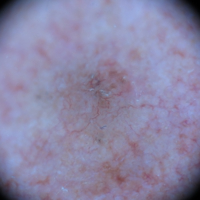

In [32]:
img = open_image(dm.get_dataset_path().ls()[0]);img

In [33]:
img.shape

torch.Size([3, 200, 200])

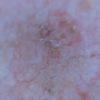

In [34]:
crop(img,100)

In [81]:
asd= Path('asd')

In [83]:
asd.rmdir()

FileNotFoundError: [Errno 2] No such file or directory: 'asd'